In [256]:
import torch
import torchvision
import cv2
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets

ModuleNotFoundError: No module named 'cv2'

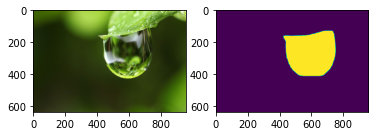

In [ ]:
## R-CNN model based on resnet50
# define the Mask R-CNN model
model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)

# set the model to evaluation mode
model.eval()

# load an input image from disk
# image_path = "2756332192_2ceb2a2791_b.jpg"
image_path = "56725fe9957df02f228ff47f43624f4d.jpg"
input_image = cv2.imread(image_path)
input_image = cv2.cvtColor(input_image, cv2.COLOR_BGR2RGB)

# convert the input image to a PyTorch tensor
input_tensor = torchvision.transforms.functional.to_tensor(input_image)

# add a batch dimension to the input tensor
input_tensor = input_tensor.unsqueeze(0)

# pass the input tensor through the model
output = model(input_tensor)

# extract the bounding boxes, labels, and masks from the output
boxes = output[0]['boxes']
labels = output[0]['labels']
masks = output[0]['masks']

# convert the tensor masks to numpy arrays
masks = masks[0].permute(1, 2, 0).detach().cpu().numpy()

# create a binary mask for each object
binary_masks = []
for i in range(masks.shape[-1]):
    binary_mask = np.zeros(masks[:,:,i].shape)
    binary_mask[masks[:,:,i] > 0.5] = 1
    binary_masks.append(binary_mask)

# plot the input image and the masks
fig, axs = plt.subplots(1, len(binary_masks) + 1)
axs[0].imshow(input_image)
for i, binary_mask in enumerate(binary_masks):
    axs[i + 1].imshow(binary_mask)
plt.show()

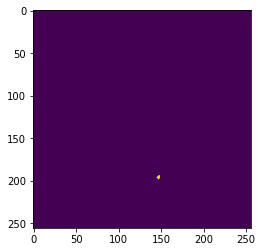

In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image


# Load the pre-trained ResNet101 model
model = models.segmentation.fcn_resnet101(pretrained=True)


# Set the model to evaluation mode
model.eval()

# Load an example image
image = Image.open('Test_Images\drop_s100_v15_r0.5_str6_pos0.png')


# Remove the alpha channel
if image.mode == 'RGBA':
    image = image.convert('RGB')

# Define the transformation pipeline to preprocess the image
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

# Preprocess the image
image_tensor = transform(image).unsqueeze(0)

# Pass the preprocessed image through the model to obtain a segmentation map
output = model(image_tensor)['out']

# Convert the output tensor to a probability map and extract the predicted class labels
probabilities = nn.functional.softmax(output, dim=1)
_, predicted_labels = torch.max(probabilities, dim=1)

# Visualize the segmentation map
predicted_labels = predicted_labels.squeeze().detach().cpu().numpy()
plt.imshow(predicted_labels)
plt.show()

In [ ]:
## Create own FCN
# Load packages
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# Define the FCN model
class FCN(nn.Module):
    def __init__(self, num_classes=2):
        super(FCN, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv5 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.conv6 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.conv7 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv8 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.conv9 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv10 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv11 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv12 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv13 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.pool5 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv14 = nn.Conv2d(512, 4096, kernel_size=7)
        self.drop1 = nn.Dropout2d()
        self.conv15 = nn.Conv2d(4096, 4096, kernel_size=1)
        self.drop2 = nn.Dropout2d()
        self.conv16 = nn.Conv2d(4096, num_classes, kernel_size=1)
        self.upconv1 = nn.ConvTranspose2d(num_classes, num_classes, kernel_size=4, stride=2, padding=1)
        self.upconv2 = nn.ConvTranspose2d(num_classes, num_classes, kernel_size=4, stride=2, padding=1)
        self.upconv3 = nn.ConvTranspose2d(num_classes, num_classes, kernel_size=4, stride=2, padding=1)
        self.upconv4 = nn.ConvTranspose2d(num_classes, num_classes, kernel_size=4, stride=2, padding=1)
        self.upconv5 = nn.ConvTranspose2d(num_classes, num_classes, kernel_size=4, stride=2, padding=1)

    def forward(self, x):
        # Encoding path
        x = nn.functional.relu(self.conv1(x))
        x = nn.functional.relu(self.conv2(x))
        x = self.pool1(x)

        x = nn.functional.relu(self.conv3(x))
        x = nn.functional.relu(self.conv4(x))
        x = self.pool2(x)

        x = nn.functional.relu(self.conv5(x))
        x = nn.functional.relu(self.conv6(x))
        x = nn.functional.relu(self.conv7(x))
        x = self.pool3(x)

        x = nn.functional.relu(self.conv8(x))
        x = nn.functional.relu(self.conv9(x))
        x = nn.functional.relu(self.conv10(x))
        x = self.pool4(x)

        x = nn.functional.relu(self.conv11(x))
        x = nn.functional.relu(self.conv12(x))
        x = nn.functional.relu(self.conv13(x))
        x = self.pool5(x)

        x = nn.functional.relu(self.conv14(x))
        x = self.drop1(x)
        x = nn.functional.relu(self.conv15(x))
        x = self.drop2(x)
        x = self.conv16(x)

        x = self.upconv1(x)
        x = nn.functional.relu(self.conv13(x))
        x = nn.functional.relu(self.conv12(x))
        x = nn.functional.relu(self.conv11(x))
        x = self.upconv2(x)
        x = nn.functional.relu(self.conv10(x))
        x = nn.functional.relu(self.conv9(x))
        x = nn.functional.relu(self.conv8(x))
        x = self.upconv3(x)
        x = nn.functional.relu(self.conv7(x))
        x = nn.functional.relu(self.conv6(x))
        x = nn.functional.relu(self.conv5(x))
        x = self.upconv4(x)
        x = nn.functional.relu(self.conv4(x))
        x = nn.functional.relu(self.conv3(x))
        x = self.upconv5(x)
        x = nn.functional.relu(self.conv2(x))
        x = nn.functional.relu(self.conv1(x))

        return x

In [257]:
import torch
import torch.nn as nn

class FCN(nn.Module):
    def _init_(self, in_channels, out_channels):
        super(FCN, self)._init_()
        
        self.conv1 = nn.Conv2d(in_channels, 64, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU(inplace=True)
        
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.relu3 = nn.ReLU(inplace=True)
        self.conv4 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.relu4 = nn.ReLU(inplace=True)
        
        self.conv5 = nn.Conv2d(128, out_channels, kernel_size=1)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        
        x = self.pool(x)
        
        x = self.conv3(x)
        x = self.relu3(x)
        x = self.conv4(x)
        x = self.relu4(x)
        
        x = self.conv5(x)
        
        return x

# Create an instance of the FCN model
in_channels = 3  # Number of input channels
out_channels = 2  # Number of output classes
model = FCN(in_channels, out_channels)

# Test the model with dummy input
input_data = torch.randn(1, in_channels, 256, 256)  # Dummy input tensor
output = model(input_data)
print(output.shape)  # Shape of the output tensor

TypeError: __init__() takes 1 positional argument but 3 were given

In [ ]:
# Run model with x classes
model = FCN(num_classes=2)

In [ ]:
# Define criterion and optizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
# optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

In [ ]:
# Define the image transformation pipeline
# transform = transforms.Compose([
#     transforms.Resize((256, 256)),
#     transforms.ToTensor(),
    
# ])
transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize the image to a specific size
    transforms.ToTensor(),  # Convert PIL image to tensor
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize the image

])

In [ ]:
# In this example, the CustomDataset takes in two lists of file paths: image_list and mask_list, representing the paths to the images and their corresponding masks, 
# respectively. It also takes in an optional transform argument to apply any necessary transformations to the images and masks.
import os
class CustomDataset(Dataset):
    def __init__(self, image_list, mask_list, transform=None):
        # self.image_list = image_list
        # self.mask_list = mask_list
        self.image_list = [os.path.join(image_list, f) for f in os.listdir(image_list)]
        self.mask_list = [os.path.join(mask_list, f) for f in os.listdir(mask_list)]
        self.transform = transform

    def __len__(self):
        return len(self.image_list)

    def __getitem__(self, idx):
        image_path = self.image_list[idx]
        mask_path = self.mask_list[idx]
        image = Image.open(image_path)
        image = image.convert('RGB')
        mask = Image.open(mask_path)
        mask = mask.convert('RGB')

        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)

        return image, mask

In [ ]:
# Load the data
train_data = CustomDataset('Droplet_XY/','Droplet_Mask_XY/', transform=transform)
# val_data = CustomDataset('val_data_path', 'val_label_path', transform=transform)


In [ ]:
# Define the data loader
batch_size = 32
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
# val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)

# for i, (images, labels) in enumerate(train_loader):
#     print(type(images))

In [ ]:
num_epochs = 10

for epoch in range(num_epochs):
    # Set the model to training mode
    model.train()
    
    # Iterate over the training data
    for i, (images, labels) in enumerate(train_loader):
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(images)
        
        # Compute the loss
        loss = criterion(outputs, labels)
        
        # Backward pass
        loss.backward()
        
        # Update the parameters
        optimizer.step()
        
        # Print the loss every 10 batches
        if i % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Batch [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}')
    
    # Set the model to evaluation mode
    model.eval()
    
    # Compute the validation loss
    # val_loss = 0.0
    # with torch.no_grad():
    #     for images, labels in val_loader:
    #         # Forward pass
    #         outputs = model(images)
            
    #         # Compute the loss
    #         loss = criterion(outputs, labels)
            
    #         # Accumulate the loss over all batches
    #         val_loss += loss.item() * images.size(0)
    
    # # Compute the average validation loss
    # val_loss /= len(val_data)
    # print(f'Epoch [{epoch+1}/{num_epochs}] , Val Loss: {val_loss:.4f}')

RuntimeError: Given groups=1, weight of size [512, 512, 3, 3], expected input[32, 2, 4, 4] to have 512 channels, but got 2 channels instead

In [ ]:
# Save model
torch.save(model.state_dict(), 'fcn_model.pt')

In [ ]:
# Load model
model = FCN()
model.load_state_dict(torch.load('fcn_model.pt'))